In [58]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/segment-anything'
import sys
sys.path.append("..")
sys.path.append(curr_dir)
from segment_anything import SamPredictor, sam_model_registry
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import time
from skimage import io

In [37]:
im_file = '/user_data/vayzenbe/GitHub_Repos/kornet/stim/_things/dog/dog_01b.jpg'
im_file = '/user_data/vayzenbe/image_sets/ecoset/val/0001_man/n09895480_2584.JPEG'
image = cv2.imread(im_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#resize image to 224x224
image = cv2.resize(image, (224, 224))

#image = Image.(im_file)

sam_checkpoint = f"{curr_dir}/checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [35]:
#specify center of the image as numpy array
center = input_point = np.array([[112,112]])
input_label = np.array([1])


In [25]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda')

predictor = SamPredictor(sam)

In [59]:


start = time.time()
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
end = time.time()
print(end - start)

1.6363205909729004


In [60]:
#convert boolean mask to uint8
masks = masks.astype(np.uint8)
#sum masks along the channel axis
mask = np.sum(masks, axis=0)
#binarize
mask = (mask > 0).astype(np.uint8)

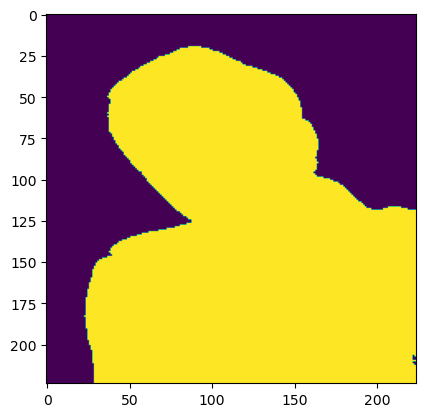

In [48]:
plt.imshow(mask)

In [63]:
mask_im =  np.interp(mask, (mask.min(), mask.max()), (0, 255))

io.imsave('test.jpg', mask_im)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [55]:
#convert mask to PIL image
mask_im = Image.fromarray(np.uint8(mask), mode='L')
#convert to rgb
#mask_im = mask_im.convert("RGB")
#save mask
mask_im.save(f"test.jpg")

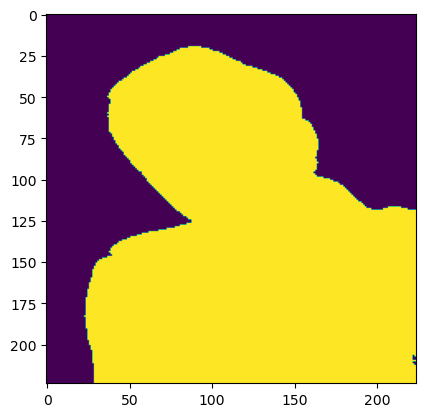

In [56]:
plt.imshow(mask_im)

#sav

In [21]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

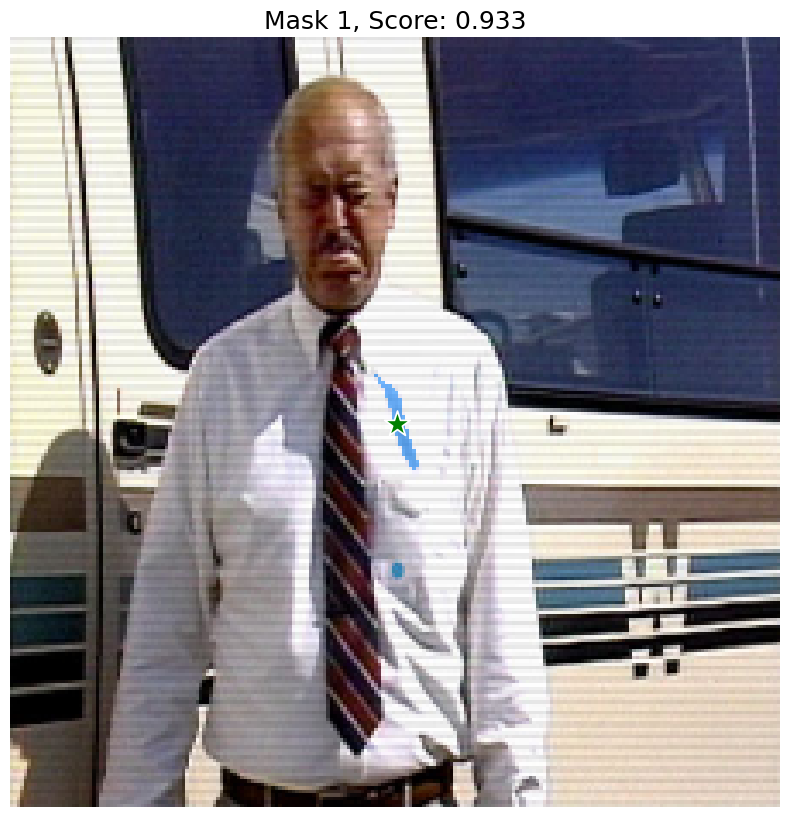

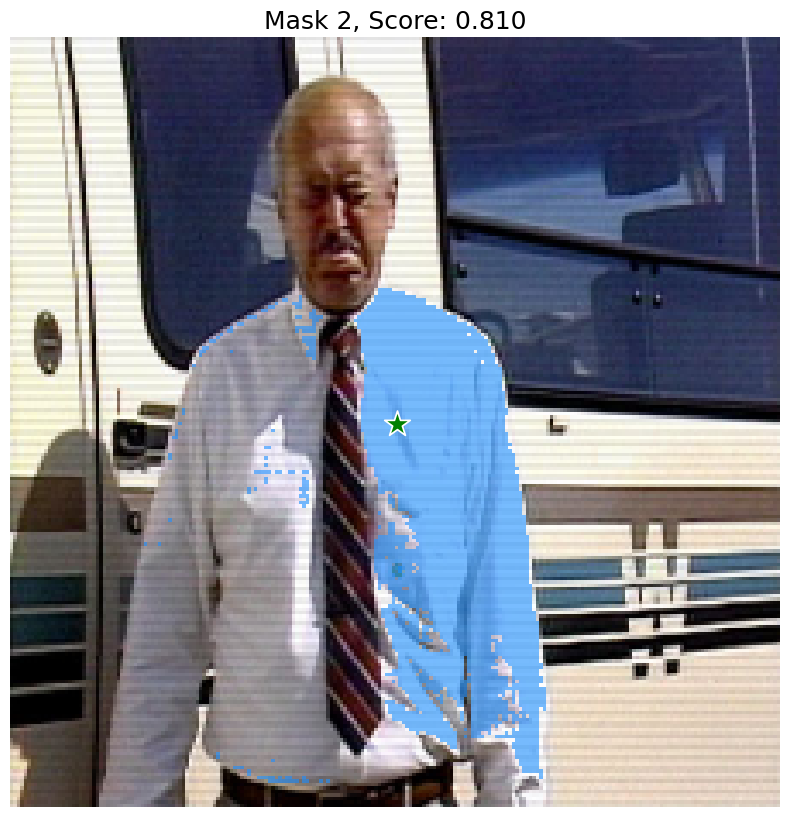

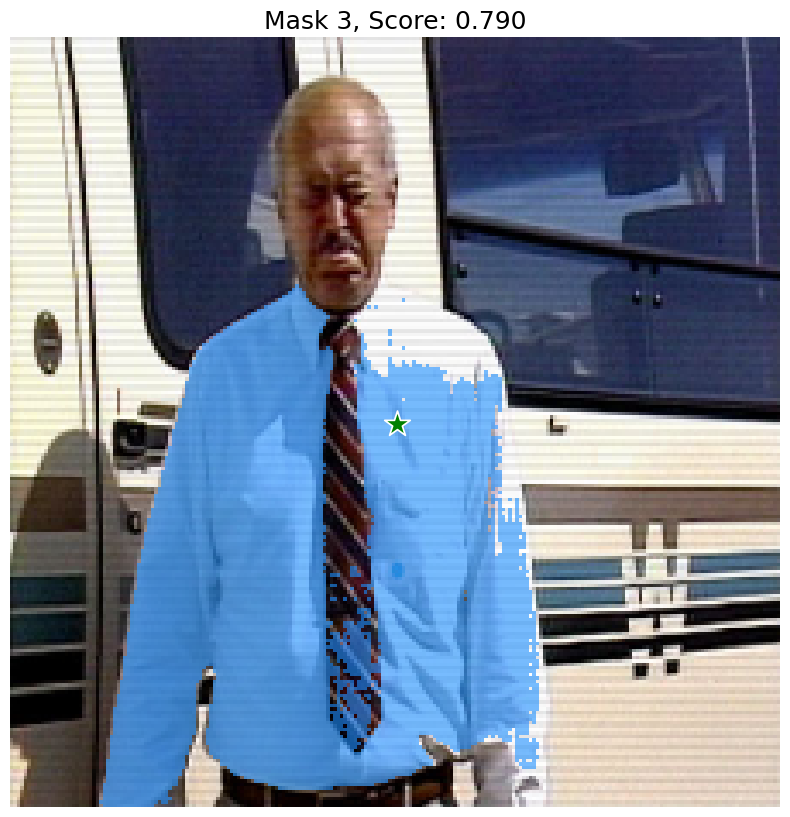

In [22]:
masks.shape  # (number_of_masks) x H x W
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## pytorh seg

In [70]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.transforms.functional import to_pil_image

img = read_image(im_file)

# Step 1: Initialize model with the best available weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/vayzenbe/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 88.7MB/s] 


In [78]:
# Step 4: Use the model and visualize the prediction
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, 0]


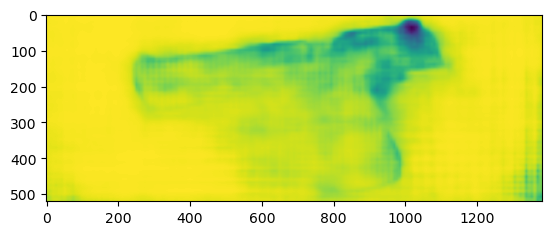

In [79]:
#convert mask to numpy
mask = mask.cpu().detach().numpy()

plt.imshow(mask)

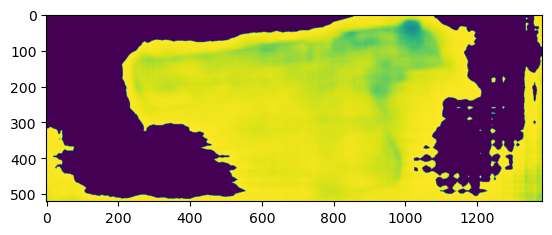

In [80]:
#threshold mask using using upper quantile
mask[mask > np.quantile(mask, 0.6)] = 0



plt.imshow(mask)